In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
week_data = pd.read_csv('assets/full_position.csv')

In [3]:
week_data.week.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17],
      dtype=int64)

In [4]:
week_data.head()

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route,week
0,2018-09-07T01:07:14.599Z,91.73,26.67,0.00,0.01,0.02,289.57,240.93,None,310.0,Matt Ryan,2.0,QB,1,away,2018090600,75,left,NaN,1
1,2018-09-07T01:07:14.599Z,88.89,36.47,0.01,0.01,0.01,105.63,66.66,None,79848.0,Malcolm Jenkins,27.0,SS,1,home,2018090600,75,left,NaN,1
2,2018-09-07T01:07:14.599Z,91.35,44.16,0.02,0.03,0.01,290.45,16.86,None,2495454.0,Julio Jones,11.0,WR,1,away,2018090600,75,left,HITCH,1
3,2018-09-07T01:07:14.599Z,86.31,22.01,0.09,0.42,0.01,70.12,168.91,None,2495613.0,Corey Graham,24.0,FS,1,home,2018090600,75,left,NaN,1
4,2018-09-07T01:07:14.599Z,90.78,36.15,0.00,0.00,0.00,257.61,193.97,None,2533040.0,Mohamed Sanu,12.0,WR,1,away,2018090600,75,left,HITCH,1


In [5]:
week_data = week_data[week_data['week']==5]

In [6]:
week_data.head()

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route,week
4591687,2018-10-05T00:23:49.700Z,86.56,30.79,0.0,0.0,0.0,260.09,311.40,None,238498.0,Julian Edelman,11.0,WR,1,home,2018100400,51,left,HITCH,5
4591688,2018-10-05T00:23:49.700Z,85.54,34.83,0.0,0.0,0.0,301.97,279.57,None,497240.0,Rob Gronkowski,87.0,TE,1,home,2018100400,51,left,GO,5
4591689,2018-10-05T00:23:49.700Z,90.23,23.65,0.0,0.0,0.0,275.51,261.21,None,2504211.0,Tom Brady,12.0,QB,1,home,2018100400,51,left,NaN,5
4591690,2018-10-05T00:23:49.700Z,86.47,15.91,0.0,0.0,0.0,283.76,234.57,None,2530515.0,Chris Hogan,15.0,WR,1,home,2018100400,51,left,HITCH,5
4591691,2018-10-05T00:23:49.700Z,85.62,8.77,0.0,0.0,0.0,266.56,172.17,None,2537931.0,Josh Gordon,10.0,WR,1,home,2018100400,51,left,GO,5


In [7]:
# Check dataframe. There are some null values in nflId.
week_data.describe()

,x,y,s,a,dis,o,dir,nflId,jerseyNumber,frameId,gameId,playId,week
count,1.171908e+06,1.171908e+06,1.171908e+06,1.171908e+06,1.171908e+06,1.092057e+06,1.092057e+06,1.092057e+06,1.092057e+06,1.171908e+06,1.171908e+06,1.171908e+06,1171908.0
mean,6.027526e+01,2.666153e+01,3.188657e+00,1.992009e+00,3.228805e-01,1.810829e+02,1.802101e+02,2.365202e+06,3.782508e+01,3.630401e+01,2.018101e+09,2.242340e+03,5.0
std,2.497171e+01,1.107521e+01,2.822739e+00,1.604656e+00,3.058559e-01,9.967845e+01,1.023125e+02,6.237653e+05,2.470364e+01,2.428520e+01,8.778512e+01,1.258602e+03,0.0
min,-6.110000e+00,-8.600000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.060000e+02,1.000000e+00,1.000000e+00,2.018100e+09,5.100000e+01,5.0
25%,4.135000e+01,1.898000e+01,9.000000e-01,7.400000e-01,9.000000e-02,9.230000e+01,9.122000e+01,2.533457e+06,2.100000e+01,1.700000e+01,2.018101e+09,1.174000e+03,5.0
50%,6.017000e+01,2.656000e+01,2.800000e+00,1.740000e+00,2.800000e-01,1.789200e+02,1.800800e+02,2.552392e+06,2.900000e+01,3.400000e+01,2.018101e+09,2.279000e+03,5.0
75%,7.861000e+01,3.434000e+01,4.910000e+00,2.920000e+00,4.900000e-01,2.703500e+02,2.697000e+02,2.557887e+06,5.300000e+01,5.100000e+01,2.018101e+09,3.295000e+03,5.0
max,1.243700e+02,6.848000e+01,2.803000e+01,4.576000e+01,7.210000e+00,3.600000e+02,3.600000e+02,2.561653e+06,9.900000e+01,2.240000e+02,2.018101e+09,4.943000e+03,5.0


In [8]:
# The null nflId column values are from the movements of the football.
# This will be filtered later in the notebook.
week_data[week_data['nflId'].isnull()]['displayName'].unique()

array(['Football'], dtype=object)

In [9]:
# Read play data.
play_data = pd.read_csv('Kaggle-Data-Files/plays.csv')

In [10]:
# Check for null values. Some yardline numbers are null.
play_data.describe()

,gameId,playId,quarter,down,yardsToGo,yardlineNumber,defendersInTheBox,numberOfPassRushers,preSnapVisitorScore,preSnapHomeScore,absoluteYardlineNumber,offensePlayResult,playResult,epa
count,1.923900e+04,19239.000000,19239.000000,19239.000000,19239.000000,19239.000000,19177.000000,18606.000000,18600.000000,18600.000000,18600.000000,19239.000000,19239.000000,19239.000000
mean,2.018107e+09,2176.217319,2.591039,1.920318,8.923905,29.860232,6.036189,4.216543,10.758333,12.465484,59.905753,6.279380,6.469047,0.020725
std,1.148060e+04,1240.919041,1.123155,0.848819,3.974216,12.444118,1.015547,0.897862,9.798115,10.552753,23.641588,10.184296,10.566605,1.580748
min,2.018091e+09,50.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,11.000000,-19.000000,-78.000000,-11.935951
25%,2.018100e+09,1125.000000,2.000000,1.000000,6.000000,21.500000,6.000000,4.000000,3.000000,3.000000,40.000000,0.000000,0.000000,-0.745327
50%,2.018110e+09,2166.000000,3.000000,2.000000,10.000000,30.000000,6.000000,4.000000,9.000000,10.000000,60.000000,4.000000,4.000000,-0.190540
75%,2.018120e+09,3203.500000,4.000000,3.000000,10.000000,40.000000,7.000000,5.000000,17.000000,20.000000,80.000000,10.000000,11.000000,0.976822
max,2.018123e+09,5661.000000,5.000000,4.000000,41.000000,50.000000,11.000000,10.000000,51.000000,54.000000,109.000000,97.000000,97.000000,8.629316


In [11]:
# Filter to include non-null yardline numbers.
play_data = play_data[play_data['absoluteYardlineNumber'].notnull()]

In [12]:
play_data.columns

Index(['gameId', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'playType', 'yardlineSide', 'yardlineNumber',
       'offenseFormation', 'personnelO', 'defendersInTheBox',
       'numberOfPassRushers', 'personnelD', 'typeDropback',
       'preSnapVisitorScore', 'preSnapHomeScore', 'gameClock',
       'absoluteYardlineNumber', 'penaltyCodes', 'penaltyJerseyNumbers',
       'passResult', 'offensePlayResult', 'playResult', 'epa',
       'isDefensivePI'],
      dtype='object')

In [13]:
# Merge movement and play-by-play datasets.
week_play = week_data.merge(play_data, on=['gameId', 'playId'])

In [14]:
week_play.shape[0]

1143423

In [15]:
# Convert time to datetime format.
week_play['time'] = pd.to_datetime(week_play['time'], format='%Y-%m-%dT%H:%M:%S')

In [16]:
# Extract the time elapsed in the play. Labeled as "time_acc_s". May take a while for full dataset.
week_play['time_diff'] = week_play.groupby(['playId', 'gameId', 'displayName'])['time'].diff()
week_play['time_diff'][week_play['time_diff'].isnull()] = pd.Timedelta(0)
week_play['time_acc_s'] = week_play.groupby(['playId', 'gameId', 'displayName'])['time_diff'].transform(
    lambda x: x.map(lambda x: x.microseconds).cumsum()).div(1e6)

<ipython-input-16-d596cb274c38>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week_play['time_diff'][week_play['time_diff'].isnull()] = pd.Timedelta(0)


In [17]:
# Load game data.
games = pd.read_csv('Kaggle-Data-Files/games.csv')

In [18]:
# Merge play-by-play and movement data with game data.
week_play_games = week_play.merge(games, on='gameId')

In [19]:
# Check values of team.
week_play_games['team'].unique()

array(['home', 'away', 'football'], dtype=object)

In [20]:
# Find which teams in the dataframe are offensive vs. defensive.
week_play_games['off'] = np.where(week_play_games['position'].isin(['QB', 'HB', 'FB', 'WR', 'TE', 'C', 'OG', 'OT', 'RB']),
                                            True, False)

In [21]:
# Check position counts for defense. All positions are correctly labelled.
week_play_games[~week_play_games['off']]['position'].value_counts()

CB     226982
OLB     97460
FS      80800
SS      57723
ILB     54856
MLB     31691
LB      24997
DB      21419
S        2278
DE        730
DL        428
K          65
P          65
DT         65
LS         65
Name: position, dtype: int64

In [22]:
# Check position counts for offense. All positions are correctly labelled.
week_play_games[week_play_games['off']]['position'].value_counts()

WR    212677
TE     92613
RB     78508
QB     77995
FB      2112
HB      2006
Name: position, dtype: int64

In [23]:
# Filter to exclude football.
week_non_foot = week_play_games[week_play_games['team'] != 'football']

In [24]:
# Extract starting x and y position.
week_non_foot['x_starting'] = week_non_foot.groupby(['gameId', 'playId', 'nflId'])['x'].transform(lambda x: x.iloc[0])
week_non_foot['y_starting'] = week_non_foot.groupby(['gameId', 'playId', 'nflId'])['y'].transform(lambda x: x.iloc[0])

<ipython-input-24-8ea911f7632b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week_non_foot['x_starting'] = week_non_foot.groupby(['gameId', 'playId', 'nflId'])['x'].transform(lambda x: x.iloc[0])
<ipython-input-24-8ea911f7632b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week_non_foot['y_starting'] = week_non_foot.groupby(['gameId', 'playId', 'nflId'])['y'].transform(lambda x: x.iloc[0])


In [25]:
# Subtract 10 from yardline to get relative to left endzone.
week_non_foot['yardline_100'] = week_non_foot['absoluteYardlineNumber'].sub(10)

<ipython-input-25-ebdd8769abfc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week_non_foot['yardline_100'] = week_non_foot['absoluteYardlineNumber'].sub(10)


In [26]:
# Extract data for offense, including yardline numbers. Used to find the yardline for the first down.
week_off = week_non_foot[week_non_foot['off']].groupby(['gameId', 'playId'])[[
    'x_starting', 'yardline_100', 'absoluteYardlineNumber', 'yardsToGo']].first().reset_index()
week_off['yardline_first'] = np.where(week_off['x_starting'].gt(week_off['absoluteYardlineNumber']),
         week_off['yardline_100'].sub(week_off['yardsToGo']),
         week_off['yardline_100'].add(week_off['yardsToGo']))

In [27]:
# No null values in the dataframe, and  the yardline ranges are all reasonable.
week_off.describe()

,gameId,playId,x_starting,yardline_100,absoluteYardlineNumber,yardsToGo,yardline_first
count,1.178000e+03,1178.000000,1178.000000,1178.000000,1178.000000,1178.00000,1178.000000
mean,2.018101e+09,2225.871817,60.517861,50.424448,60.424448,8.98472,50.475382
std,9.155019e+01,1259.344983,24.231146,23.759446,23.759446,3.80043,24.770652
min,2.018100e+09,51.000000,8.100000,1.000000,11.000000,1.00000,0.000000
25%,2.018101e+09,1149.750000,39.895000,31.000000,41.000000,7.00000,35.000000
50%,2.018101e+09,2242.500000,61.345000,51.000000,61.000000,10.00000,50.000000
75%,2.018101e+09,3288.000000,79.627500,69.000000,79.000000,10.00000,66.000000
max,2.018101e+09,4943.000000,113.640000,99.000000,109.000000,28.00000,100.000000


In [28]:
# Merge main dataframe with dataframe containing the first down yardline.
# Then extract which side offense is on.
week_first = week_non_foot.merge(week_off[['gameId', 'playId', 'yardline_first']].drop_duplicates(), on=['gameId', 'playId'])
week_first['off_pos'] = np.where(week_first['yardline_first'].gt(week_first['yardline_100']),
                                 'left', 'right')

In [29]:
# There is a roughly even split, which looks good.
week_first['off_pos'].value_counts()

left     541714
right    523821
Name: off_pos, dtype: int64

In [30]:
# Adjust starting y coordinate because the perspective would change depending on the side.
week_first['y_starting_dir'] = np.where(week_first['off_pos'] == 'right', week_first['y_starting'].rsub(53.3), week_first['y_starting'])

<AxesSubplot:xlabel='y_starting', ylabel='Count'>

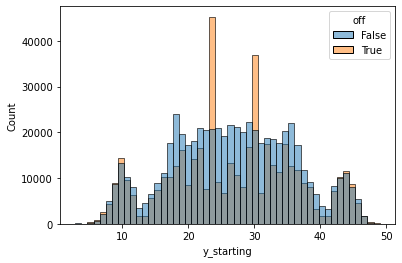

In [31]:
# Show distribution of starting y without adjustment. The values match up fairly well.
sns.histplot(data=week_first, x='y_starting', bins=50, hue='off')

<AxesSubplot:xlabel='y_starting_dir', ylabel='Count'>

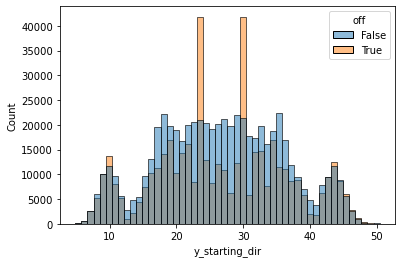

In [32]:
# The positions match up slightly better although the distributions are fairly symmetrical.
sns.histplot(data=week_first, x='y_starting_dir', bins=50, hue='off')

In [33]:
def find_rank(df, col, reverse=False):
    """
    Find the ranking of a series based on values.
    :param df: Dataframe for ranking; pd.DataFrame
    :param col: Column from dataframe to rank; str
    :param reverse: Flag of whether to reverse rank direction; bool
    :return: Array with rankings; np.array
    """
    # Extract series and use arsort to find rankings.
    ser = df[col]
    temp = np.argsort(ser)

    # Reverse direction based on flag.
    if reverse:
        temp = temp[::-1]

    # Fill ranking array.
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(ser.shape[0])
    return ranks

In [34]:
# Find the order of positions based on offensive direction.
# First, group and extract first value of the y starting position and direction.
pos_start = (week_first
 .groupby(['gameId', 'playId', 'position', 'nflId'])
 [['y_starting_dir', 'off_pos']].first()
 .reset_index())

# Next, group and extract ranking of positions based on whether team is home or away
# and the starting position.
pos_order = (pos_start.groupby(['gameId', 'playId', 'position'])
 .apply(lambda x: np.where(x['off_pos'] == 'right', find_rank(x, 'y_starting_dir'),find_rank(x, 'y_starting_dir')))
             .explode()
             .reset_index()
             )

# Add column with the position order to the df with indexed starting position.
pos_start['pos_order'] = pos_order[0]

In [35]:
# Concatenate position and position order to create unique position identifier.
pos_start['pos_num'] = pos_start.apply(lambda x: x['position'] + str(x['pos_order']), axis=1)

In [36]:
# Merge full dataframe with position number dataframe.
week_pos = week_first.merge(pos_start[['gameId', 'playId', 'nflId', 'pos_num', 'pos_order']], on=['gameId', 'playId', 'nflId'])

In [37]:
# Use regex to extract personnel from personnel column, and concatenate with main dataframe.
week_pos_pers = pd.concat([week_pos, week_pos['personnelD'].str.extract(
    '(?P<DL>\d+) DL, (?P<LB>\d+) LB, (?P<DB>\d+) DB')], axis=1)

In [38]:
# Find the position of each player relative to the line of scrimmage.
week_pos_pers['x_behind_line'] = np.where(week_pos_pers['off_pos'] == 'right',
                                     week_pos_pers['absoluteYardlineNumber'].sub(week_pos_pers['x']),
                                     week_pos_pers['x'].sub(week_pos_pers['absoluteYardlineNumber']))

<AxesSubplot:xlabel='x_behind_line', ylabel='Count'>

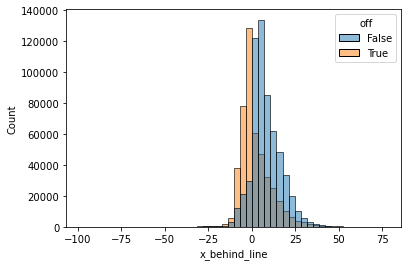

In [39]:
# Examine the x_behind_line column. The distributions seem to make sense,
# as the distribution of the offensive position has a lower mean than the defensive position.
sns.histplot(data=week_pos_pers, x='x_behind_line', bins=50, hue='off')

In [40]:
# Extract the yardline for first down and line of scrimmage based on the
# direction that the teams are facing.
week_pos_pers['yardline_first_dir'] = np.where(week_pos_pers['off_pos'] == 'right',
                                          week_pos_pers['yardline_first'],
                                          week_pos_pers['yardline_first'].rsub(100))
week_pos_pers['yardline_100_dir'] = np.where(week_pos_pers['off_pos'] == 'right',
                                        week_pos_pers['yardline_100'],
                                        week_pos_pers['yardline_100'].rsub(100))

In [41]:
# Distribution of first yardline looks good. Range is within expected.
week_pos_pers['yardline_first_dir'].describe()

count    1.065535e+06
mean     4.223601e+01
std      2.327340e+01
min      0.000000e+00
25%      2.300000e+01
50%      4.400000e+01
75%      6.500000e+01
max      8.800000e+01
Name: yardline_first_dir, dtype: float64

In [42]:
# Distribution of line of scrimmage also looks reasonable.
week_pos_pers['yardline_100_dir'].describe()

count    1.065535e+06
mean     5.134074e+01
std      2.358213e+01
min      1.000000e+00
25%      3.300000e+01
50%      5.400000e+01
75%      7.200000e+01
max      9.800000e+01
Name: yardline_100_dir, dtype: float64

In [43]:
# Check that all first downs are labelled as closer to touchdown than line of scrimmage. Looks good.
week_pos_pers['yardline_first_dir'].lt(week_pos_pers['yardline_100_dir']).value_counts()

True    1065535
dtype: int64

In [44]:
# Add flag if a player has gone at least 1 yard past the line of scrimmage.
week_pos_pers['exceeded_1yd'] = week_pos_pers.groupby(['gameId', 'playId', 'nflId'])['x_behind_line'].transform(lambda x: x.max() > 1)

In [45]:
# Use whether player is on offense, whether the player is a QB or WR, and whether a player has
# moved 1 yard beyond the line of scrimmage to determine if the player is a receiver.
week_pos_pers['receiver'] = (week_pos_pers['off'] & (week_pos_pers['position'] != 'QB') &
                            (week_pos_pers['exceeded_1yd'] | (week_pos_pers['position'] == 'WR')))

In [46]:
# Check positions that are labelled as receivers. Everything looks good.
week_pos_pers[week_pos_pers['receiver']]['position'].value_counts()

WR    212677
TE     78006
RB     51570
FB      1739
HB      1203
Name: position, dtype: int64

In [47]:
# Check value counts of players labelled receivers for offense.
# Looks reasonable given positions tracked.
week_pos_pers[week_pos_pers['off']]['receiver'].value_counts()

True     345195
False    120716
Name: receiver, dtype: int64

In [48]:
# Save offensive and defensive numbered position lists.
off_pos = week_pos_pers[week_pos_pers['off']]['pos_num'].unique()
def_pos = week_pos_pers[~week_pos_pers['off']]['pos_num'].unique()

In [49]:
# Adjust y to match direction of offense.
week_pos_pers['y_dir'] = np.where(week_pos_pers['off_pos'] == 'right', week_pos_pers['y'].rsub(53.3), week_pos_pers['y'])

In [50]:
# Next, determine minimum distances between each defensive player and receiver and qb.
# Separate defensive and receiver dataframes.
week_rec = week_pos_pers[week_pos_pers['receiver']]
week_def = week_pos_pers[~week_pos_pers['off']]

# Merge defensive with receiver dataframes on game, play, and time.
week_def_rec = week_def.merge(week_rec[['gameId', 'playId', 'time_acc_s', 'x_behind_line', 'y_dir']],
               on=['gameId', 'playId', 'time_acc_s'],
               suffixes=['_def', '_rec'])

# Find distance between each defensive player and each receiver.
week_def_rec['dist'] = np.linalg.norm(week_def_rec[['x_behind_line_def', 'y_dir_def']].values -
                                               week_def_rec[['x_behind_line_rec', 'y_dir_rec']].values, axis=1)

# Group dataframe to obtain minimum distance.
min_rec_dist = week_def_rec.groupby(['gameId', 'playId', 'time_acc_s', 'pos_num'])['dist'].min()
min_rec_dist.name = 'min_dist_rec'

# Separate QB dataframe
week_qb = week_pos_pers[week_pos_pers['position'] == 'QB']

# Merge defensive with QB dataframe.
week_def_qb = week_def.merge(week_qb[['gameId', 'playId', 'time_acc_s', 'x_behind_line', 'y_dir']],
                              on=['gameId', 'playId', 'time_acc_s'],
                              suffixes=['_def', '_qb'])

# Find distance to the QB.
week_def_qb['dist'] = np.linalg.norm(week_def_qb[['x_behind_line_def', 'y_dir_def']].values -
                                               week_def_qb[['x_behind_line_qb', 'y_dir_qb']].values, axis=1)

# Group to form index and distance.
min_qb_dist = week_def_qb.groupby(['gameId', 'playId', 'time_acc_s', 'pos_num'])['dist'].min()
min_qb_dist.name = 'dist_qb'

# Concatenate about the same index and reset the index.
min_dist = pd.concat([min_rec_dist, min_qb_dist], axis=1).reset_index()

In [51]:
# Check that the distances are in a reasonable range. The max value is a bit high, but might be on long plays.
min_dist[['min_dist_rec', 'dist_qb']].describe()

,min_dist_rec,dist_qb
count,598841.000000,598211.000000
mean,6.885296,18.277110
std,5.217732,9.456557
min,0.000000,0.020000
25%,2.750509,10.961551
50%,5.750339,17.566619
75%,9.420536,23.844146
max,57.177426,83.560954


In [52]:
# Merge main dataframe with minimum distance dataframe.
week_pos_full = week_pos_pers.merge(min_dist, on=['gameId', 'playId', 'time_acc_s', 'pos_num'], how='left')

In [53]:
# Evaluate whether a receiver is closer than the qb.
week_pos_full['rec_closer'] = week_pos_full['min_dist_rec'].lt(week_pos_full['dist_qb'])

In [54]:
# Cut time accumulated into 10 deciles for each play in order to reduce the space. Can adjust number of cuts.
n_cuts = 10
time_quart = week_pos_full.groupby(['gameId', 'playId'])['time_acc_s'].agg(lambda x: np.nan if x.nunique() < n_cuts else
                        pd.qcut(x.unique(), n_cuts, labels=range(1, n_cuts + 1), duplicates='drop')).explode().dropna()

In [55]:
# Extract the time quartile index, as the quartiles do not include time accumulated in the index.
time_quart_index = (week_pos_full[
                        week_pos_pers.groupby(['gameId', 'playId'])['time_acc_s'].transform(lambda x: x.nunique() >= n_cuts)]
                    .reset_index()
                    .sort_values(['gameId', 'playId', 'time_acc_s'])
                    [['gameId', 'playId', 'time_acc_s']].drop_duplicates())

In [56]:
time_quart_index.head()

,gameId,playId,time_acc_s
0,2018100400,51,0.000
1,2018100400,51,0.099
2,2018100400,51,0.200
3,2018100400,51,0.300
4,2018100400,51,0.399


In [57]:
# Set time_quart column equal to time quartile values.
time_quart_index['time_quart'] = time_quart.values

In [58]:
# Merge dataframe with time quartiles to main dataframe.
week_full_time = week_pos_full.merge(time_quart_index, on=['gameId', 'playId', 'time_acc_s'])

<AxesSubplot:xlabel='pos_num', ylabel='time_quart'>

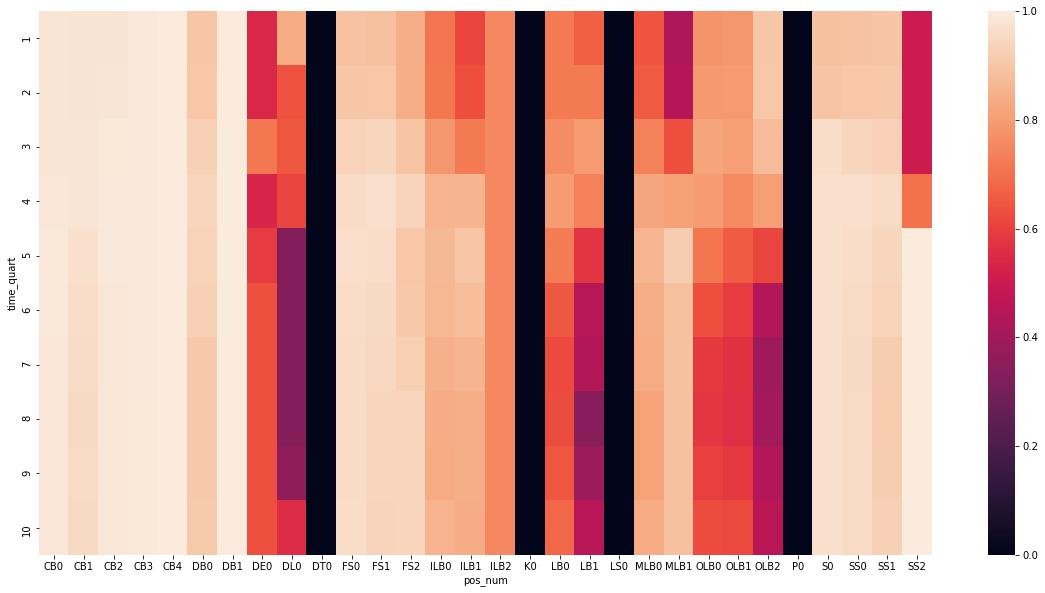

In [59]:
# Check average time
# Although all positions average closer to the receiver for each time decile,
# the positional distribution seem to make sense, with cornerbacks and safeties
# closest to the receivers.
week_rec_closer = week_full_time[~week_full_time['off']].groupby(['gameId', 'playId', 'time_quart', 'pos_num'])['rec_closer'].mean().reset_index()
rec_closer_def = week_rec_closer.groupby(['pos_num', 'time_quart'])['rec_closer'].mean().reset_index()
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(rec_closer_def.pivot_table(index='time_quart', columns='pos_num', values='rec_closer'), ax=ax)

In [60]:
# Aggregate columns based on game, play, numbered position, and time quartile.
def_full = week_full_time[~week_full_time['off'] & (week_full_time['position'] != 'TE')].groupby(['gameId', 'playId', 'pos_num', 'time_quart']).agg(
    {'x_starting': 'first', 'y_starting': 'first',
     'yardline_100_dir': 'first', 'yardline_first_dir': 'first',
     'defendersInTheBox': 'first',
     'numberOfPassRushers': 'first',
     'DL': 'first', 'LB': 'first', 'DB': 'first',
     'x_behind_line': 'mean', 'y_dir': 'mean', 'min_dist_rec': 'mean',
     'dist_qb': 'mean', 'rec_closer': 'mean'}
).reset_index()

In [61]:
# Pivot table based on play.
week_def_pivot = def_full.pivot_table(values=['rec_closer', 'dist_qb', 'min_dist_rec'],
                                           index=['gameId', 'playId', 'DL', 'LB', 'DB',
                                                  'yardline_first_dir', 'yardline_100_dir', 'defendersInTheBox',
                                                  'numberOfPassRushers'],
                                           columns=['pos_num', 'time_quart']).reset_index()

In [62]:
week_def_pivot.shape

(1177, 789)

In [63]:
# All of the index columns are full and do not have null values. Need to fill the null values in
# receiver columns with fill value.
week_def_pivot.describe()

gameId       playId yardline_first_dir yardline_100_dir  \
pos_num                                                                     
time_quart                                                                  
count       1.177000e+03  1177.000000        1177.000000      1177.000000   
mean        2.018101e+09  2226.439252          41.813934        50.800340   
std         9.158803e+01  1259.729640          23.356856        23.734001   
min         2.018100e+09    51.000000           0.000000         1.000000   
25%         2.018101e+09  1149.000000          23.000000        33.000000   
50%         2.018101e+09  2245.000000          43.000000        53.000000   
75%         2.018101e+09  3289.000000          64.000000        71.000000   
max         2.018101e+09  4943.000000          88.000000        98.000000   

           defendersInTheBox numberOfPassRushers      dist_qb               \
pos_num                                                   CB0                
time_quart                                                  1            2   
count            1177.000000         1177.000000  1172.000000  1172.000000   
mean                6.041631            4.220901    17.135809    17.273135   
std                 1.024761            0.893365     4.504778     4.532743   
min                 3.000000            0.000000     4.782981     5.458318   
25%                 5.000000            4.000000    13.912862    14.040520   
50%                 6.000000            4.000000    17.071885    17.242551   
75%                 7.000000            5.000000    20.694448    20.857338   
max                11.000000            8.000000    42.902768    42.455868   

                                      ... rec_closer                      \
pos_num                               ...        SS2                       
time_quart            3            4  ...          1         2         3   
count       1172.000000  1172.000000  ...   2.000000  2.000000  2.000000   
mean          18.002839    19.633944  ...   0.500000  0.500000  0.500000   
std            4.684504     5.055270  ...   0.707107  0.707107  0.707107   
min            4.441673     1.679924  ...   0.000000  0.000000  0.000000   
25%           14.810027    16.286338  ...   0.250000  0.250000  0.250000   
50%           18.019012    19.558863  ...   0.500000  0.500000  0.500000   
75%           21.662413    23.280438  ...   0.750000  0.750000  0.750000   
max           43.927885    46.069918  ...   1.000000  1.000000  1.000000   

                                                    
pos_num                                             
time_quart         4    5    6    7    8    9   10  
count       2.000000  2.0  2.0  2.0  2.0  2.0  2.0  
mean        0.700000  1.0  1.0  1.0  1.0  1.0  1.0  
std         0.424264  0.0  0.0  0.0  0.0  0.0  0.0  
min         0.400000  1.0  1.0  1.0  1.0  1.0  1.0  
25%         0.550000  1.0  1.0  1.0  1.0  1.0  1.0  
50%         0.700000  1.0  1.0  1.0  1.0  1.0  1.0  
75%         0.850000  1.0  1.0  1.0  1.0  1.0  1.0  
max         1.000000  1.0  1.0  1.0  1.0  1.0  1.0  

[8 rows x 786 columns]